In [ ]:
# ============================================================================
#       Import Libraries 
# ============================================================================
# !pip install -U accelerate for the transformer updated version 

import pandas as pd
import matplotlib.pyplot as plt              
import seaborn as sns                        
import numpy as np
import re
import nltk
import string
import time
import requests
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from typing import List, Dict, Set, Optional
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

from xgboost import XGBClassifier # type: ignore
from sklearn.decomposition import LatentDirichletAllocation 
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments # pyright: ignore[reportMissingImports]
from transformers import TrainerCallback # type: ignore
import torch # type: ignore
from torch.utils.data import Dataset # type: ignore
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    os.environ['KMP_DUPLICATE_LIB_OK']='True' 
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not found. Install with: pip install xgboost")
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

import shap
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#----------------------------------------------------------------------
#                        Data Collection 
#----------------------------------------------------------------------

# europepmc_fetch_topup_5cats.py
# Goal: Get EXACTLY 200 (or as close as possible) per category by using
# (1) strict query, then (2) broader fallback query, then (3) backup query if needed.
# Saves:
#   - per-category CSVs
#   - one combined CSV with (up to) 1000 rows (balanced per-category)
#
# pip install pandas requests

BASE_URL = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"

def safe_filename(name: str) -> str:
    return re.sub(r"[^a-zA-Z0-9_\-]+", "_", name.strip())

def fetch_europepmc(
    query: str,
    category: str,
    target_n: int,
    seen_ids: Optional[Set[str]] = None,
    page_size: int = 100,
    sleep_s: float = 0.6,
    max_pages: int = 600,
    min_abstract_chars: int = 150,
    only_english: bool = False,
) -> pd.DataFrame:
    """
    Fetch up to target_n *new* records for a category using cursor-based pagination.
    Keeps only items with both title and abstract.
    Skips doc_ids already in seen_ids (within category).
    """
    if seen_ids is None:
        seen_ids = set()

    session = requests.Session()
    headers = {"User-Agent": "mental-health-text-classification/3.0"}

    cursor = "*"
    rows: List[dict] = []
    pages = 0

    def request_json(params: dict, retries: int = 6) -> dict:
        backoff = 1.0
        for _ in range(retries):
            r = session.get(BASE_URL, params=params, headers=headers, timeout=45)
            if r.status_code == 429:
                time.sleep(backoff)
                backoff = min(backoff * 2, 30)
                continue
            if r.status_code != 200:
                raise RuntimeError(f"[{category}] HTTP {r.status_code}: {r.text[:300]}")
            return r.json()
        raise RuntimeError(f"[{category}] Repeated 429 rate limits; increase sleep_s.")

    while len(rows) < target_n and pages < max_pages:
        params = {
            "query": query,
            "format": "json",
            "resultType": "core",
            "pageSize": page_size,
            "cursorMark": cursor,
        }

        data = request_json(params)
        results = data.get("resultList", {}).get("result", [])
        if not results:
            break

        for item in results:
            title = (item.get("title") or "").strip()
            abstract = (item.get("abstractText") or "").strip()
            if not title or not abstract:
                continue
            if min_abstract_chars and len(abstract) < min_abstract_chars:
                continue

            if only_english:
                lang = (item.get("language") or "").strip().lower()
                if lang and lang != "eng":
                    continue

            doc_id = item.get("doi") or item.get("pmid") or item.get("id")
            if not doc_id or doc_id in seen_ids:
                continue

            seen_ids.add(doc_id)
            rows.append({
                "category": category,
                "doc_id": doc_id,
                "doi": item.get("doi"),
                "pmid": item.get("pmid"),
                "source": item.get("source"),
                "year": item.get("pubYear"),
                "journal": item.get("journalTitle"),
                "authors": item.get("authorString"),
                "title": title,
                "abstract": abstract,
                "query_used": query,
            })

            if len(rows) >= target_n:
                break

        next_cursor = data.get("nextCursorMark")
        if not next_cursor or next_cursor == cursor:
            break
        cursor = next_cursor
        pages += 1
        time.sleep(sleep_s)

    df = pd.DataFrame(rows)
    return df

def fetch_with_topups(
    category: str,
    queries_in_order: List[str],
    target_n: int = 200,
    **fetch_kwargs
) -> pd.DataFrame:
    """
    Run multiple queries in order, topping up until target_n is reached or queries exhausted.
    Deduping is done within category using seen_ids.
    """
    seen_ids: Set[str] = set()
    collected = []

    remaining = target_n
    for q in queries_in_order:
        if remaining <= 0:
            break
        df = fetch_europepmc(q, category, target_n=remaining, seen_ids=seen_ids, **fetch_kwargs)
        collected.append(df)
        remaining = target_n - sum(len(x) for x in collected)

        print(f"  -> Query returned {len(df)} new. Remaining to reach {target_n}: {remaining}")

    out = pd.concat(collected, ignore_index=True) if collected else pd.DataFrame()
    # Safety dedupe within category
    if not out.empty:
        out = out.drop_duplicates(subset=["doc_id"]).reset_index(drop=True)
    return out

if __name__ == "__main__":
    TARGET = 200

    # Three-tier query strategy per category:
    # - Q1: precise
    # - Q2: broader (remove some constraints / add synonyms)
    # - Q3: backup (even broader; still in-genre)

    CATEGORY_QUERIES: Dict[str, List[str]] = {

        "Depression_NLP_Detection": [
            '(depression OR "major depressive disorder" OR MDD) '
            'AND ("natural language processing" OR NLP OR "text mining" OR "language model") '
            'AND (detect* OR screen* OR classif* OR identif* OR predict*)',

            '(depression OR "major depressive disorder" OR MDD) '
            'AND ("natural language processing" OR NLP OR "text mining")',

            '(depression OR "major depressive disorder") '
            'AND (NLP OR "natural language processing")'
        ],

        "Anxiety_ML_Disorders": [
            '(anxiety OR "anxiety disorder*" OR GAD OR "panic disorder") '
            'AND ("machine learning" OR "deep learning" OR "artificial intelligence") '
            'AND (detect* OR predict* OR classif* OR screen* OR severity)',

            '(anxiety OR "anxiety disorder*" OR GAD) '
            'AND ("machine learning" OR "deep learning" OR "artificial intelligence")',

            '(anxiety OR "anxiety disorder*") '
            'AND ("machine learning" OR "deep learning")'
        ],

        # This is the hard one: suicide + NLP is narrower than suicide + ML.
        # We allow text-based signals and clinical notes.
        "SuicideRisk_NLP_Assessment": [
            '(suicide OR "suicidal ideation" OR "self-harm") '
            'AND ("natural language processing" OR NLP OR "text mining" OR "language model") '
            'AND (risk OR assess* OR predict* OR detect* OR classif*)',

            '(suicide OR "suicidal ideation" OR "self-harm") '
            'AND ("clinical notes" OR EHR OR "electronic health record*" OR "clinical narrative") '
            'AND ("machine learning" OR "deep learning" OR "artificial intelligence" OR NLP)',

            '(suicide OR "suicidal ideation" OR "self-harm") '
            'AND ("machine learning" OR "deep learning" OR "artificial intelligence")'
        ],

        "PTSD_ML_Diagnosis": [
            '(PTSD OR "post-traumatic stress disorder") '
            'AND ("machine learning" OR "deep learning" OR "artificial intelligence") '
            'AND (detect* OR predict* OR classif* OR screen* OR severity)',

            '(PTSD OR "post-traumatic stress disorder") '
            'AND ("machine learning" OR "deep learning" OR "artificial intelligence")',

            '(PTSD OR "post-traumatic stress disorder") '
            'AND ("machine learning" OR "deep learning")'
        ],

        # Psychiatric EHR + NLP is niche; broaden to clinical text + mental health concepts.
        "PsychiatricEHR_NLP": [
            '("psychiatric" OR "mental health") '
            'AND ("electronic health record*" OR EHR OR "clinical note*" OR "medical record*") '
            'AND ("natural language processing" OR NLP OR "information extraction" OR "text mining" OR "named entity recognition")',

            '(psychiatr* OR "mental health" OR depression OR anxiety OR PTSD OR schizophrenia) '
            'AND ("electronic health record*" OR EHR OR "clinical note*" OR "clinical narrative" OR "progress note*" OR "discharge summary") '
            'AND ("natural language processing" OR NLP OR "text mining" OR "information extraction")',

            '(psychiatr* OR "mental health") '
            'AND ("clinical note*" OR "electronic health record*" OR EHR) '
            'AND (NLP OR "natural language processing" OR "text mining")'
        ],
    }

    all_category_dfs = []

    for cat, query_list in CATEGORY_QUERIES.items():
        print(f"\n=== {cat}: target {TARGET} ===")
        df_cat = fetch_with_topups(
            category=cat,
            queries_in_order=query_list,
            target_n=TARGET,
            page_size=100,
            sleep_s=0.7,          # increase if you see 429
            max_pages=800,
            min_abstract_chars=150,  # relax to 100 if still short
            only_english=False,      # can set True later if you want
        )

        print(f"Collected for {cat}: {len(df_cat)}")
        all_category_dfs.append(df_cat)

    # IMPORTANT: do NOT dedupe across categories if you want balanced labels.
    combined = pd.concat(all_category_dfs, ignore_index=True)

    combined.to_csv("Mental Health DataSet.csv", index=False)

    print("\n=== Final summary ===")
    print(combined["category"].value_counts())
    print("Combined rows:", len(combined))
    print("Saved combined file: all_mental_health_5cats_200_each.csv")



=== Depression_NLP_Detection: target 200 ===
  -> Query returned 200 new. Remaining to reach 200: 0
Collected for Depression_NLP_Detection: 200

=== Anxiety_ML_Disorders: target 200 ===
  -> Query returned 200 new. Remaining to reach 200: 0
Collected for Anxiety_ML_Disorders: 200

=== SuicideRisk_NLP_Assessment: target 200 ===
  -> Query returned 200 new. Remaining to reach 200: 0
Collected for SuicideRisk_NLP_Assessment: 200

=== PTSD_ML_Diagnosis: target 200 ===
  -> Query returned 200 new. Remaining to reach 200: 0
Collected for PTSD_ML_Diagnosis: 200

=== PsychiatricEHR_NLP: target 200 ===
  -> Query returned 200 new. Remaining to reach 200: 0
Collected for PsychiatricEHR_NLP: 200

=== Final summary ===
category
Depression_NLP_Detection      200
Anxiety_ML_Disorders          200
SuicideRisk_NLP_Assessment    200
PTSD_ML_Diagnosis             200
PsychiatricEHR_NLP            200
Name: count, dtype: int64
Combined rows: 1000
Saved combined file: all_mental_health_5cats_200_each.csv

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   category    1000 non-null   object 
 1   doc_id      1000 non-null   object 
 2   doi         994 non-null    object 
 3   pmid        962 non-null    float64
 4   source      1000 non-null   object 
 5   year        1000 non-null   int64  
 6   journal     0 non-null      float64
 7   authors     1000 non-null   object 
 8   title       1000 non-null   object 
 9   abstract    1000 non-null   object 
 10  query_used  1000 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 86.1+ KB
None

--- First 5 Rows ---
                   category                           doc_id  \
0  Depression_NLP_Detection              10.3390/jcm15020834   
1  Depression_NLP_Detection  10.12688/f1000research.168964.1   
2  Depression_NLP_Detection          10.3390/nursrep160100

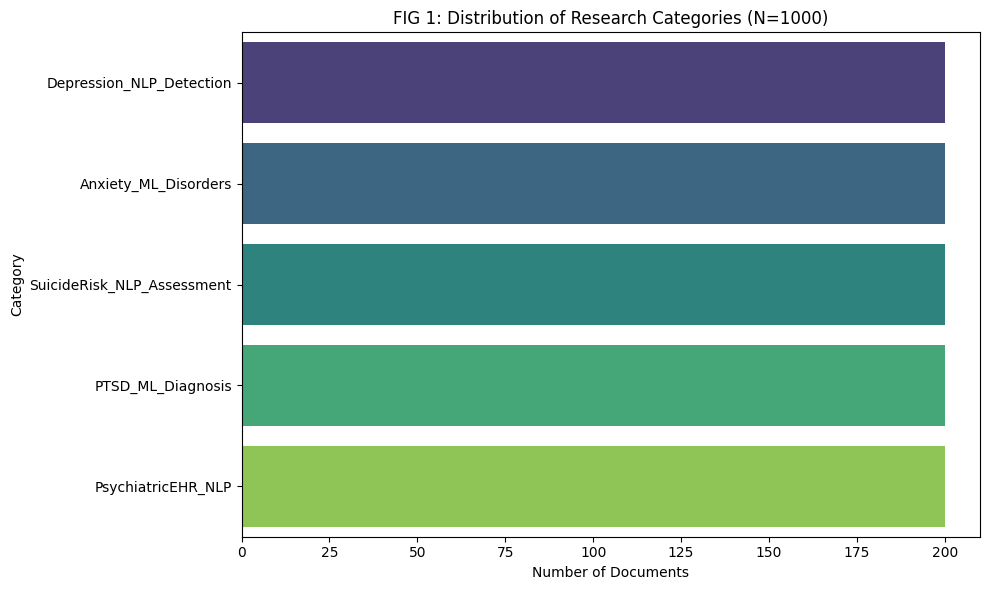

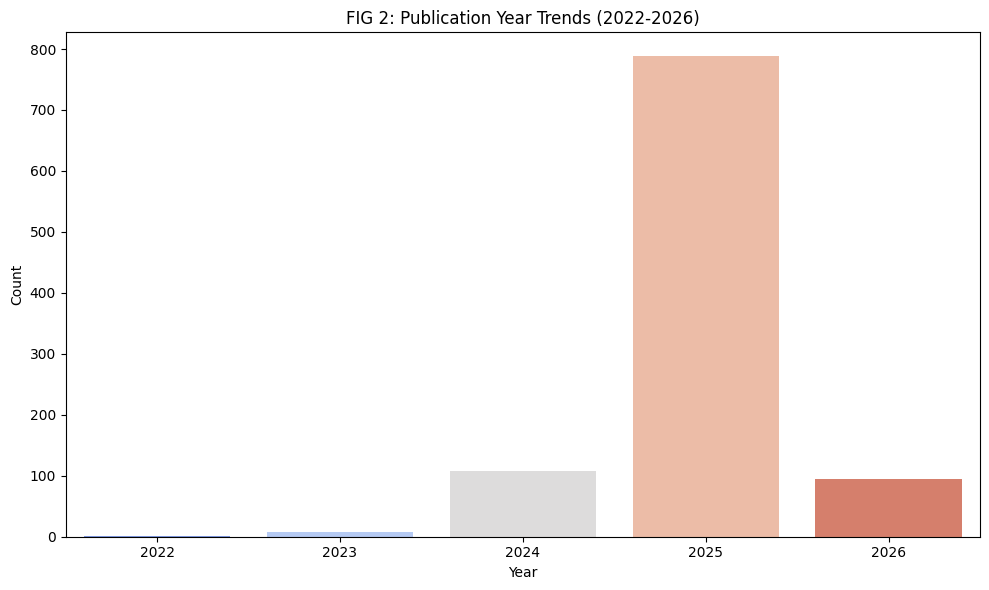

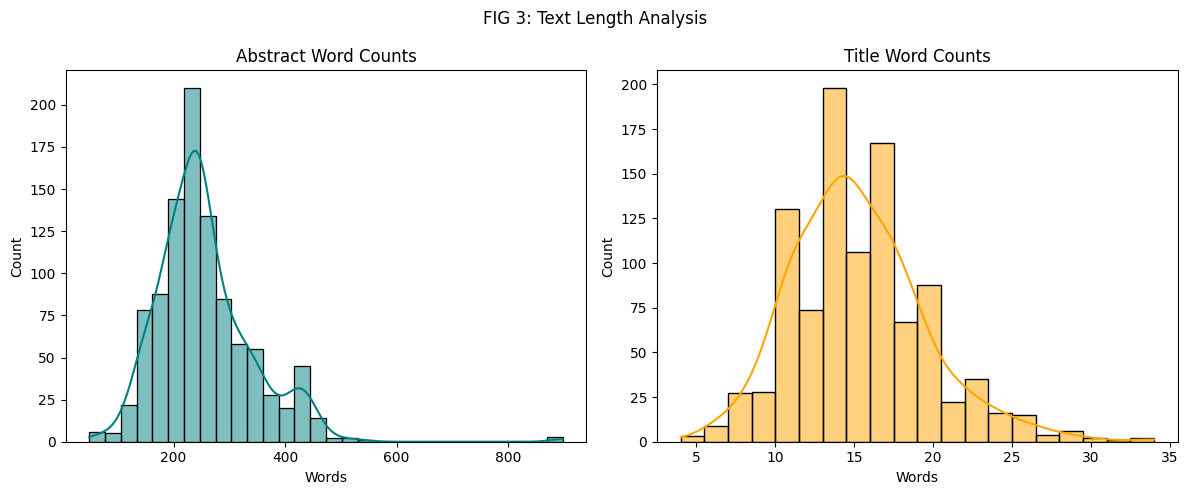

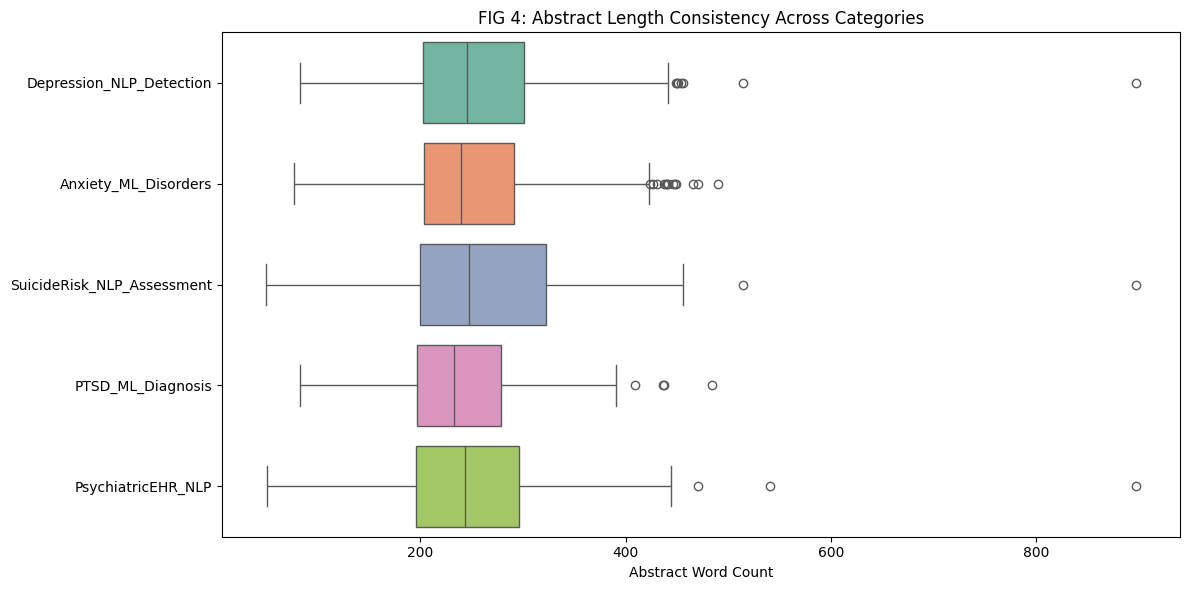

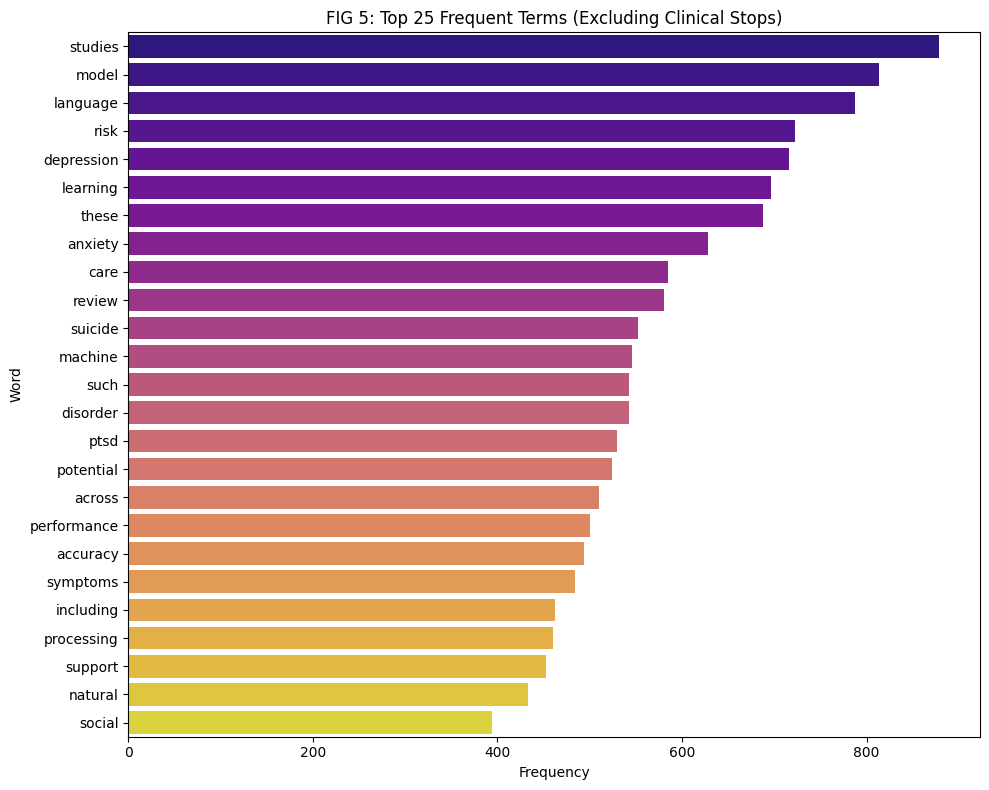

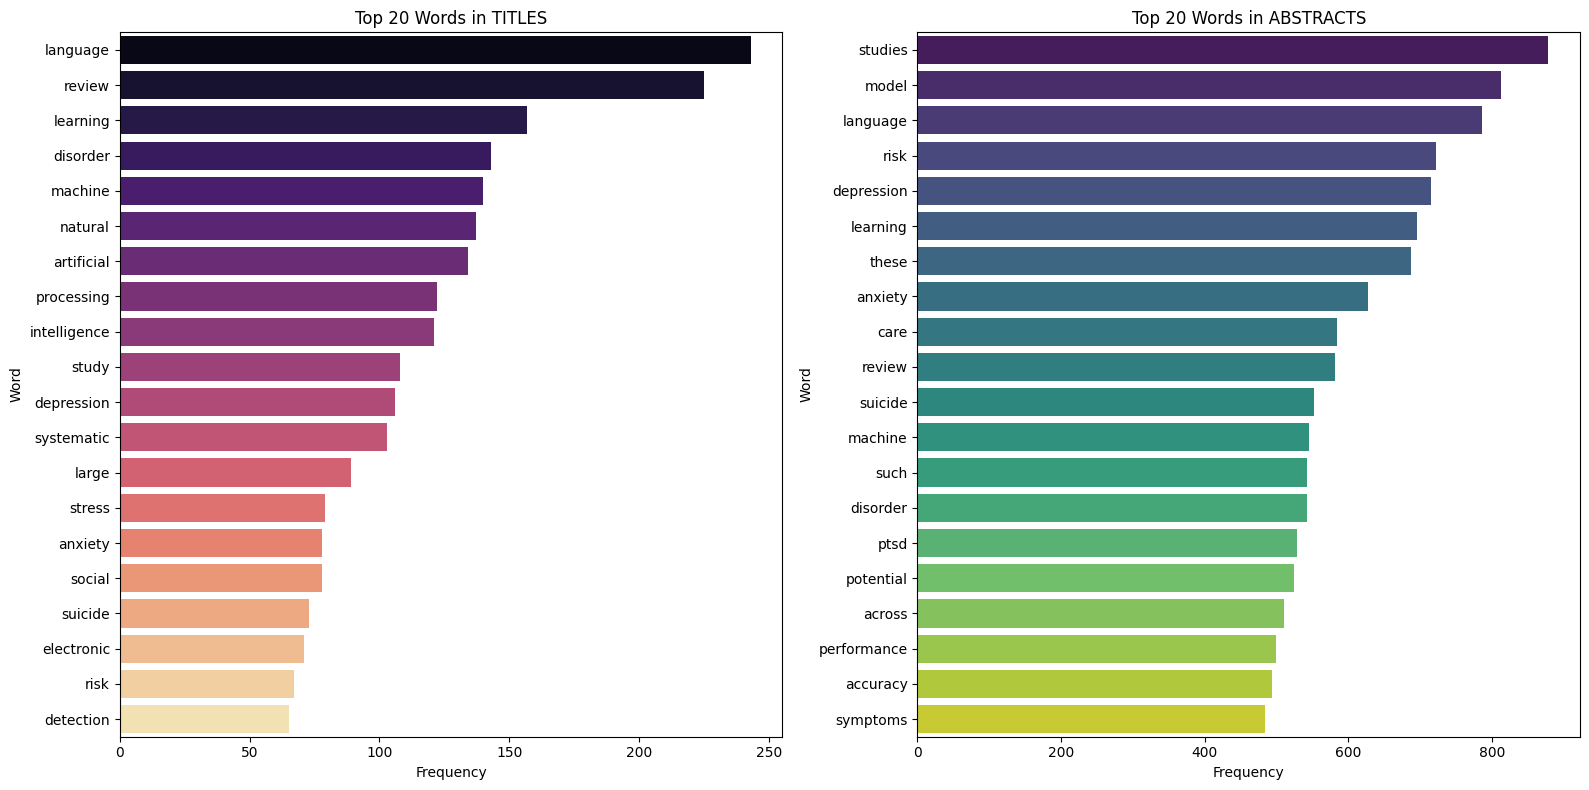

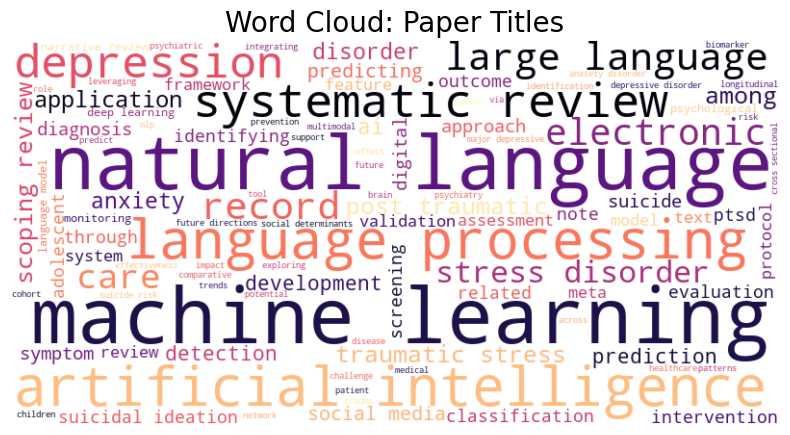

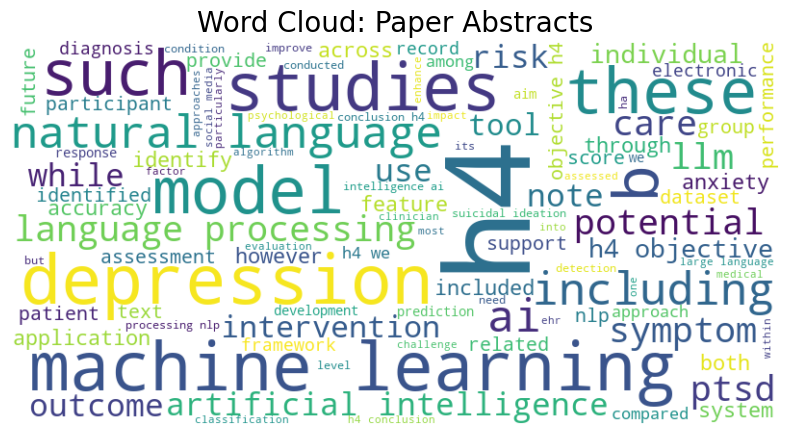

In [3]:
#----------------------------------------------------------------------
#                        Data Exploration
#----------------------------------------------------------------------
# 1. Load the dataset
df = pd.read_csv('Mental Health DataSet.csv')

# Basic inspection
print("--- Dataset Info ---")
print(df.info())
print("\n--- First 5 Rows ---")
print(df.head())

# Missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Category distribution
print("\n--- Category Distribution ---")
cat_counts = df['category'].value_counts()
print(cat_counts)

# Year distribution
print("\n--- Year Summary ---")
print(df['year'].describe())

# Text length analysis
df['title_len'] = df['title'].str.split().str.len()
df['abstract_len'] = df['abstract'].str.split().str.len()

print("\n--- Text Length Summary (Word Count) ---")
print(df[['title_len', 'abstract_len']].describe())


# 2. Setup Text Processing (Manual stopword list for cleaner signal)
STOPWORDS = set([
    'the', 'and', 'a', 'of', 'to', 'in', 'is', 'for', 'with', 'on', 'as', 'by', 'an', 'at', 'this', 'that', 'it', 'from', 'are', 'was', 'be', 'or', 'which', 'study', 'patients', 'results', 'clinical', 'using', 'used', 'research', 'between', 'abstract', 'methods', 'background', 'conclusions', 'treatment', 'health', 'mental', 'associated', 'data', 'models', 'analysis', 'based', 'more', 'their', 'were', 'also', 'have', 'been', 'can', 'may'
])

# Calculate basic length metrics
df['title_wc'] = df['title'].fillna('').apply(lambda x: len(x.split()))
df['abstract_wc'] = df['abstract'].fillna('').apply(lambda x: len(x.split()))

# --- VISUALIZATION 1: Category Distribution ---
plt.figure(figsize=(10, 6))
order = df['category'].value_counts().index
sns.countplot(data=df, y='category', order=order, palette='viridis')
plt.title('FIG 1: Distribution of Research Categories (N=1000)')
plt.xlabel('Number of Documents')
plt.ylabel('Category')
plt.tight_layout()

# --- VISUALIZATION 2: Publication Year Trends ---
plt.figure(figsize=(10, 6))
year_counts = df['year'].value_counts().sort_index()
sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, palette='coolwarm')
plt.title('FIG 2: Publication Year Trends (2022-2026)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()

# --- VISUALIZATION 3: Text Length Distribution ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['abstract_wc'], bins=30, color='teal', kde=True)
plt.title('Abstract Word Counts')
plt.xlabel('Words')

plt.subplot(1, 2, 2)
sns.histplot(df['title_wc'], bins=20, color='orange', kde=True)
plt.title('Title Word Counts')
plt.xlabel('Words')
plt.suptitle('FIG 3: Text Length Analysis')
plt.tight_layout()

# --- VISUALIZATION 4: Word Count Distribution by Category ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='abstract_wc', y='category', palette='Set2')
plt.title('FIG 4: Abstract Length Consistency Across Categories')
plt.xlabel('Abstract Word Count')
plt.ylabel('')
plt.tight_layout()

# --- VISUALIZATION 5: Top 25 Contextual Terms ---
all_text = " ".join(df['abstract'].fillna('')).lower()
words = [w.strip(".,()!?:;\"'[]") for w in all_text.split() if len(w) > 3 and w not in STOPWORDS]
common_25 = Counter(words).most_common(25)
df_common = pd.DataFrame(common_25, columns=['Word', 'Count'])

plt.figure(figsize=(10, 8))
sns.barplot(data=df_common, x='Count', y='Word', palette='plasma')
plt.title('FIG 5: Top 25 Frequent Terms (Excluding Clinical Stops)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()

# Print Final Summary Statistics
print("--- EDA COMPLETE ---")
print(f"Total Papers: {len(df)}")
print(f"Categories: {df['category'].nunique()}")
print(f"Avg Abstract Words: {df['abstract_wc'].mean():.1f}")
print(f"Year Range: {int(df['year'].min())} to {int(df['year'].max())}")

# --- Side-by-Side Top Terms Analysis ---

def get_top_words(text_list, stop_list, n=20):
    all_text = " ".join(text_list.fillna('')).lower()
    # Clean and split
    words = [w.strip(".,()!?:;\"'[]") for w in all_text.split() 
             if len(w) > 3 and w not in stop_list]
    return Counter(words).most_common(n)

# 1. Get Top Words for Title
title_common = get_top_words(df['title'], STOPWORDS, 20)
df_title_words = pd.DataFrame(title_common, columns=['Word', 'Count'])

# 2. Get Top Words for Abstract
abstract_common = get_top_words(df['abstract'], STOPWORDS, 20)
df_abstract_words = pd.DataFrame(abstract_common, columns=['Word', 'Count'])

# 3. Plotting
plt.figure(figsize=(16, 8))

# Subplot 1: Titles
plt.subplot(1, 2, 1)
sns.barplot(data=df_title_words, x='Count', y='Word', palette='magma')
plt.title('Top 20 Words in TITLES')
plt.xlabel('Frequency')

# Subplot 2: Abstracts
plt.subplot(1, 2, 2)
sns.barplot(data=df_abstract_words, x='Count', y='Word', palette='viridis')
plt.title('Top 20 Words in ABSTRACTS')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

#____________________________________________
# --- Category Keyword Heatmap (Structural Analysis) ---
from wordcloud import WordCloud

# 1. Combine all text for Titles and Abstracts
title_text = " ".join(df['title'].fillna('').astype(str)).lower()
abstract_text = " ".join(df['abstract'].fillna('').astype(str)).lower()

# 2. Function to generate and display cloud
def show_wordcloud(text, title_name, color_map):
    # We use the STOPWORDS list defined earlier to keep the cloud clean
    wc = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        stopwords=STOPWORDS,
        colormap=color_map,
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title_name, fontsize=20)
    plt.show() # Prints directly to VS Code / Jupyter

# 3. Execute
show_wordcloud(title_text, 'Word Cloud: Paper Titles', 'magma')
show_wordcloud(abstract_text, 'Word Cloud: Paper Abstracts', 'viridis')

In [4]:
#----------------------------------------------------------------------
#                        Data Pre-Processing
#----------------------------------------------------------------------

# segment_documents_100_words.py
# Creates ~100-word segments (a, b, c...) from title + abstract
# SAFE for ML: preserves doc_id to avoid data leakage later

INPUT_PATH = "Mental Health DataSet.csv"

OUTPUT_PATH = "Mental_Health_Segments_100w.csv"

SEGMENT_SIZE = 100  # words per segment


def clean_text(text: str) -> str:
    """Basic text normalization (no aggressive cleaning)."""
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text.strip()


def segment_text(words, segment_size=100):
    """Yield chunks of words of length ~segment_size."""
    for i in range(0, len(words), segment_size):
        yield words[i:i + segment_size]


def segment_id_from_index(idx: int) -> str:
    """Convert 0 -> a, 1 -> b, 2 -> c, ..."""
    return chr(ord("a") + idx)


def main():
    df = pd.read_csv(INPUT_PATH)

    required_cols = {"doc_id", "category", "title", "abstract"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Dataset must contain columns: {required_cols}")

    segmented_rows = []

    for _, row in df.iterrows():
        doc_id = row["doc_id"]
        category = row["category"]

        full_text = f"{row['title']} {row['abstract']}"
        full_text = clean_text(full_text)

        words = full_text.split()

        if len(words) < SEGMENT_SIZE:
            # keep short documents as a single segment
            segmented_rows.append({
                "category": category,
                "doc_id": doc_id,
                "segment_id": "a",
                "text": full_text,
                "word_count": len(words)
            })
            continue

        for i, chunk in enumerate(segment_text(words, SEGMENT_SIZE)):
            segment_text_str = " ".join(chunk)
            segmented_rows.append({
                "category": category,
                "doc_id": doc_id,
                "segment_id": segment_id_from_index(i),
                "text": segment_text_str,
                "word_count": len(chunk)
            })

    segmented_df = pd.DataFrame(segmented_rows)

    segmented_df.to_csv(OUTPUT_PATH, index=False)

    print("Segmentation complete.")
    print("Total documents:", df["doc_id"].nunique())
    print("Total segments:", len(segmented_df))
    print("\nSegments per category:")
    print(segmented_df["category"].value_counts())
    print(f"\nSaved to: {OUTPUT_PATH}")


if __name__ == "__main__":
    main()


Segmentation complete.
Total documents: 821
Total segments: 3199

Segments per category:
category
SuicideRisk_NLP_Assessment    662
Depression_NLP_Detection      648
Anxiety_ML_Disorders          646
PsychiatricEHR_NLP            636
PTSD_ML_Diagnosis             607
Name: count, dtype: int64

Saved to: Mental_Health_Segments_100w.csv


In [5]:
#----------------------------------------------------------------------
#      Training (70%), Validation (15%), and Testing (15%).
#----------------------------------------------------------------------
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

INPUT_SEGMENTS = "Mental_Health_Segments_100w.csv"
OUT_TRAIN = "train_segments.csv"
OUT_VAL = "val_segments.csv"
OUT_TEST = "test_segments.csv"
OUT_SPLIT_MAP = "doc_split_map.csv"

RANDOM_STATE = 42
TRAIN_FRAC = 0.70
VAL_FRAC = 0.15
TEST_FRAC = 0.15

def main():
   
    df = pd.read_csv(INPUT_SEGMENTS)

    required = {"category", "doc_id", "segment_id", "text"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns in segments file: {missing}")

    # --- Build doc-level table for stratification ---
    doc_tbl = (
        df.groupby(["doc_id", "category"])
        .size()
        .reset_index(name="n_segments")
        .sort_values(["doc_id", "n_segments"], ascending=[True, False])
        .drop_duplicates(subset=["doc_id"], keep="first")
        .reset_index(drop=True)
    )

    doc_ids = doc_tbl["doc_id"].values
    doc_labels = doc_tbl["category"].values

    # --- First split: Train vs Temp (Val+Test) ---
    sss1 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=(1.0 - TRAIN_FRAC),
        random_state=RANDOM_STATE
    )
    train_idx, temp_idx = next(sss1.split(doc_ids, doc_labels))
    train_docs = set(doc_ids[train_idx])
    temp_docs = doc_ids[temp_idx]
    temp_labels = doc_labels[temp_idx]

    # --- Second split: Val vs Test ---
    val_share_within_temp = VAL_FRAC / (VAL_FRAC + TEST_FRAC)

    sss2 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=(1.0 - val_share_within_temp),
        random_state=RANDOM_STATE
    )
    val_idx, test_idx = next(sss2.split(temp_docs, temp_labels))
    val_docs = set(temp_docs[val_idx])
    test_docs = set(temp_docs[test_idx])

    # --- Assign segments to splits using doc_id grouping ---
    train_df = df[df["doc_id"].isin(train_docs)].copy()
    val_df = df[df["doc_id"].isin(val_docs)].copy()
    test_df = df[df["doc_id"].isin(test_docs)].copy()

    # Save
    train_df.to_csv(OUT_TRAIN, index=False)
    val_df.to_csv(OUT_VAL, index=False)
    test_df.to_csv(OUT_TEST, index=False)

    print("Done splitting (doc-level, leak-safe).")
    print(f"Train docs: {len(train_docs)} | Val docs: {len(val_docs)} | Test docs: {len(test_docs)}")

if __name__ == "__main__":
    main()

Done splitting (doc-level, leak-safe).
Train docs: 574 | Val docs: 123 | Test docs: 124


In [12]:
#----------------------------------------------------------------------------------------
#      Model Training and Evalutaiotn  (Feature Engineering and Text Representation )
#------------------------------------------------------------------------------------------


RANDOM_STATE = 42
TRAIN_PATH = "train_segments.csv"
VAL_PATH = "val_segments.csv"
TEST_PATH = "test_segments.csv"
OUT_CV_RESULTS = "cv_results.csv"

def make_pipelines():
    """Defines feature-model combinations for the model training"""
    feats = {
        "BOW_uni": CountVectorizer(max_features=20000),
        "TFIDF_12": TfidfVectorizer(max_features=30000, ngram_range=(1, 2)),
    }

    models = {
        "NB": MultinomialNB(),
        "SVM": LinearSVC(max_iter=10000),
        "SGD_log": SGDClassifier(loss="log_loss", random_state=RANDOM_STATE),
        "RF": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE),
        "LogReg": LogisticRegression(max_iter=5000, n_jobs=-1),
    }

    if XGBOOST_AVAILABLE:
        models["XGBoost"] = XGBClassifier(
            n_estimators=150, max_depth=4, learning_rate=0.1,
            random_state=RANDOM_STATE, n_jobs=-1, eval_metric='mlogloss'
        )
    
    pipes = []
    for feat_name, vect in feats.items():
        for model_name, clf in models.items():
            pipes.append((f"{feat_name}__{model_name}", Pipeline([("vect", vect), ("clf", clf)])))
    return pipes

def run_ml_tournament(train_df, le):
    """Runs GroupKFold CV and saves results."""
    X = train_df["text"].astype(str)
    # Important: XGBoost needs numeric y
    y = le.transform(train_df["category"].astype(str))
    groups = train_df["doc_id"].astype(str)

    cv = GroupKFold(n_splits=10) # Reduced to 5 for speed; use 10 for final report
    results = []

    all_pipes = make_pipelines()
    print(f"Starting model Analysis with {len(all_pipes)} models...")

    for name, pipe in all_pipes:
        print(f"  Processing: {name}")
        try:
            # n_jobs=1 here to avoid macOS multiprocessing hangs
            scores = cross_validate(
                pipe, X, y, cv=cv.split(X, y, groups=groups),
                scoring=["accuracy", "f1_macro"], n_jobs=1
            )
            results.append({
                "model": name,
                "cv_acc": np.mean(scores["test_accuracy"]),
                "cv_f1": np.mean(scores["test_f1_macro"])
            })
        except Exception as e:
            print(f"  Error with {name}: {e}")

    df_results = pd.DataFrame(results).sort_values("cv_f1", ascending=False)
    df_results.to_csv(OUT_CV_RESULTS, index=False)
    return df_results

def run_lda(df):
    """Semantic Analysis: Topic Modeling."""
    print("\n Extracting Topics (LDA)...")
    vect = CountVectorizer(max_features=1000, stop_words='english')
    bow = vect.fit_transform(df["text"])
    lda = LatentDirichletAllocation(n_components=5, random_state=RANDOM_STATE)
    lda.fit(bow)
    
    words = vect.get_feature_names_out()
    for i, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[-8:]
        print(f"  Topic {i}: {', '.join([words[j] for j in top_indices])}")

def run_word2vec(df):
    """Semantic Analysis: Word Embeddings."""
    print("\n Training Word2Vec Embeddings...")
    sentences = [text.lower().split() for text in df["text"]]
    w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
    #w2v.save("word2vec_model.bin")
    try:
        sims = w2v.wv.most_similar("depression", topn=3)
        print(f"  Words similar to 'depression': {sims}")
    except:
        pass

# --- Execution ---
if __name__ == "__main__":
    # Load Data
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)

    # Initialize LabelEncoder once 
    le = LabelEncoder()
    le.fit(train_df["category"])

    # 1. Run model training 
    results = run_ml_tournament(train_df, le)
    print("\n" + "="*30 + "\nTOP 5 MODELS\n" + "="*30)
    print(results.head(5).to_string(index=False))

    # 2. Evaluate the Champion on the Test Set
    champion_name = results.iloc[0]["model"]
    print(f"\n Champion Model selected: {champion_name}")
    
    pipes_dict = dict(make_pipelines())
    champion_pipe = pipes_dict[champion_name]
    
    # Fit on full training data
    champion_pipe.fit(train_df["text"], le.transform(train_df["category"]))
    
    # Predict on test data
    y_test_encoded = le.transform(test_df["category"])
    y_pred_encoded = champion_pipe.predict(test_df["text"])
    
    print("\n--- FINAL TEST SET PERFORMANCE ---")
    print(classification_report(y_test_encoded, y_pred_encoded, target_names=le.classes_))

    # 3. Semantic Analysis (LDA & Word2Vec)
    run_lda(train_df)
    run_word2vec(train_df)

Starting model Analysis with 12 models...
  Processing: BOW_uni__NB
  Processing: BOW_uni__SVM
  Processing: BOW_uni__SGD_log
  Processing: BOW_uni__RF
  Processing: BOW_uni__LogReg
  Processing: BOW_uni__XGBoost
  Processing: TFIDF_12__NB
  Processing: TFIDF_12__SVM
  Processing: TFIDF_12__SGD_log
  Processing: TFIDF_12__RF
  Processing: TFIDF_12__LogReg
  Processing: TFIDF_12__XGBoost

TOP 5 MODELS
            model   cv_acc    cv_f1
 TFIDF_12__LogReg 0.566350 0.557784
TFIDF_12__SGD_log 0.561427 0.552505
TFIDF_12__XGBoost 0.556937 0.547457
      BOW_uni__RF 0.564526 0.546358
 BOW_uni__XGBoost 0.550703 0.545226

 Champion Model selected: TFIDF_12__LogReg

--- FINAL TEST SET PERFORMANCE ---
                            precision    recall  f1-score   support

      Anxiety_ML_Disorders       0.54      0.68      0.60        94
  Depression_NLP_Detection       0.60      0.30      0.40       100
         PTSD_ML_Diagnosis       0.58      0.71      0.64        87
        PsychiatricEHR_NLP 

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


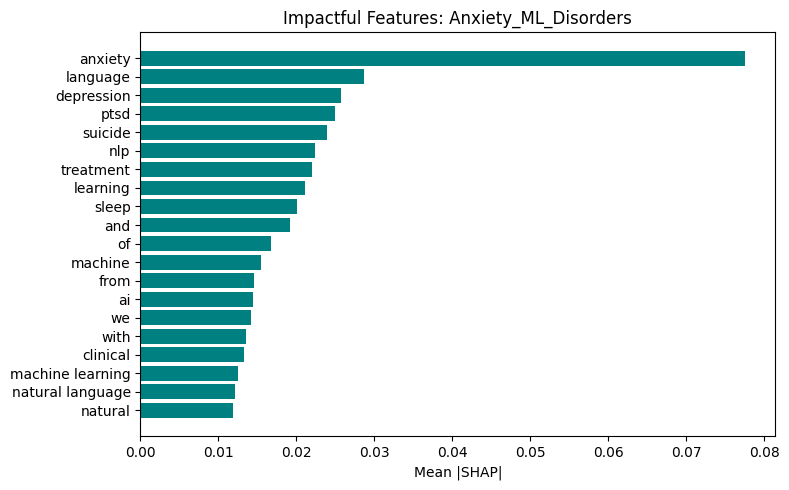

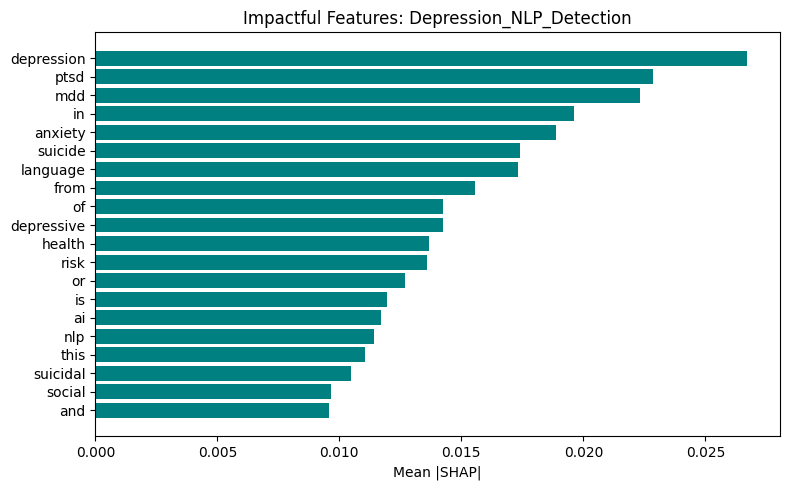

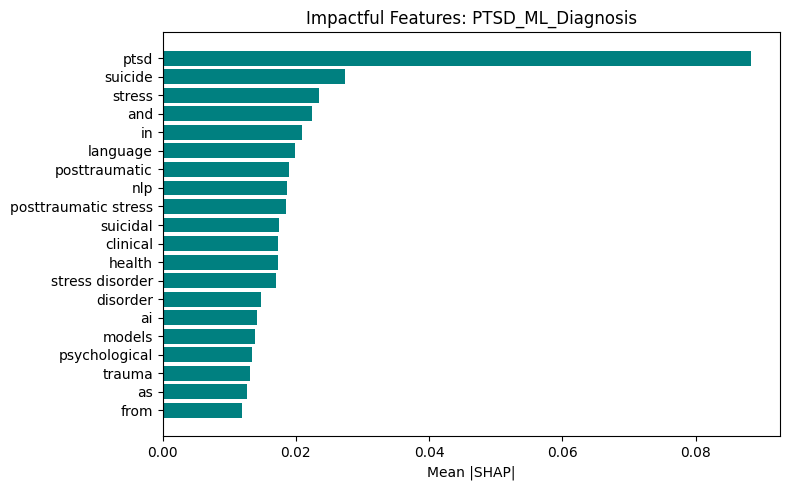

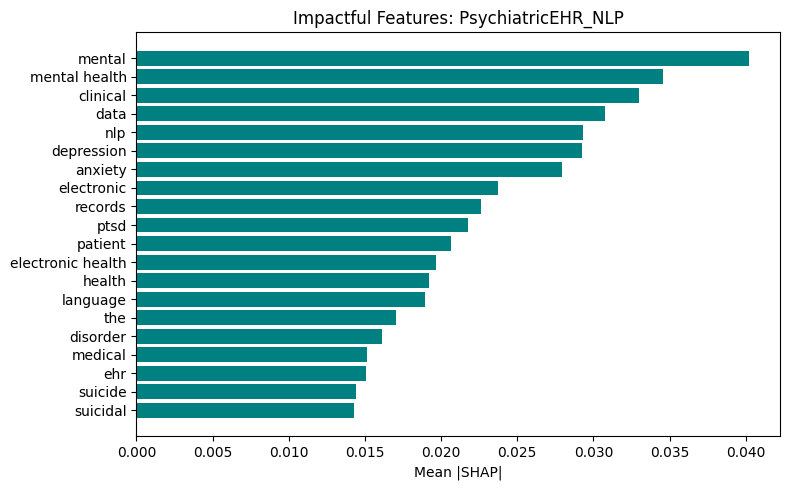

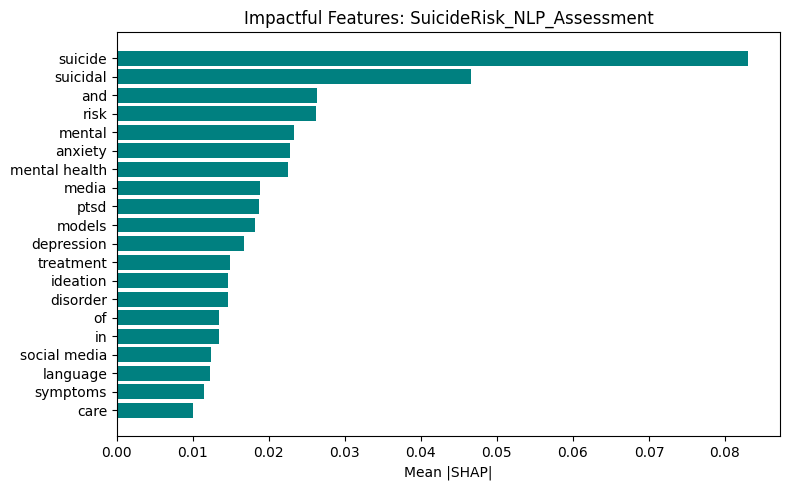

 Success! Files saved: shap_top_features_per_class.csv, shap_local_explanations.txt


In [13]:
#----------------------------------------------------------------------------------------
#                      Explainability and Error Analysis (SHAP)
#----------------------------------------------------------------------------------------
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

# ---------- Configuration ----------
TRAIN_PATH = "train_segments.csv"
VAL_PATH   = "val_segments.csv"
TEST_PATH  = "test_segments.csv"
OUT_TOP_FEATURES = "shap_top_features_per_class.csv"
OUT_LOCAL_TXT = "shap_local_explanations.txt"
RANDOM_STATE = 42

def build_champion_repro():
    """Rebuilds the champion (TF-IDF + LogReg)."""
    return Pipeline([
        ("vect", TfidfVectorizer(max_features=30000, ngram_range=(1, 2))),
        ("clf", LogisticRegression(max_iter=6000, n_jobs=-1, random_state=RANDOM_STATE))
    ])

def run_shap_explanations(pipe, train_df, val_df, n_local=5):
    """Generates Global and Local SHAP explanations."""
    vect = pipe.named_steps["vect"]
    clf = pipe.named_steps["clf"]

    X_train_vec = vect.transform(train_df["text"].astype(str))
    X_val_vec = vect.transform(val_df["text"].astype(str))
    
    feature_names = np.array(vect.get_feature_names_out())
    class_names = clf.classes_

    # 1. SHAP Explainer
    explainer = shap.LinearExplainer(clf, X_train_vec, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_val_vec)

    # Standardize format for multiclass
    if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        shap_list = [shap_values[:, :, i] for i in range(shap_values.shape[2])]
    else:
        shap_list = shap_values

    rows = []
    for ci, cname in enumerate(class_names):
        sv = shap_list[ci]
        mean_abs = np.asarray(np.abs(sv)).mean(axis=0)
        top_idx = np.argsort(mean_abs)[::-1][:20]

        # Save data for CSV (Split into shorter lines to avoid SyntaxErrors)
        for rank, j in enumerate(top_idx, start=1):
            rows.append({
                "class": cname, 
                "rank": rank,
                "feature": feature_names[j], 
                "mean_abs_shap": float(mean_abs[j])
            })

        # Plotting
        plt.figure(figsize=(8, 5))
        plt.barh(feature_names[top_idx][::-1], mean_abs[top_idx][::-1], color='teal')
        plt.title(f"Impactful Features: {cname}")
        plt.xlabel("Mean |SHAP|")
        plt.tight_layout()
        plt.show()

    pd.DataFrame(rows).to_csv(OUT_TOP_FEATURES, index=False)

    # 2. Local Error Analysis
    val_text = val_df["text"].astype(str)
    y_val = val_df["category"].astype(str).values
    val_pred = pipe.predict(val_text)
    mis_idx = np.where(val_pred != y_val)[0]

    with open(OUT_LOCAL_TXT, "w", encoding="utf-8") as f:
        f.write("ERROR ANALYSIS: MISCLASSIFIED EXAMPLES\n" + "="*40 + "\n")
        for i in mis_idx[:n_local]:
            f.write(f"\nTRUE: {y_val[i]} | PRED: {val_pred[i]}\n")
            f.write(f"TEXT: {val_text.iloc[i][:300]}...\n")
            
            # Predictor analysis for the wrong class
            pred_ci = np.where(class_names == val_pred[i])[0][0]
            sv_row = np.asarray(shap_list[pred_ci][i]).ravel()
            nz = X_val_vec[i].nonzero()[1]
            
            contribs = sorted([(feature_names[j], sv_row[j]) for j in nz], 
                              key=lambda x: x[1], reverse=True)
            
            f.write("Features that led to the INCORRECT prediction:\n")
            for word, val in contribs[:5]:
                f.write(f"  -> {word:20s} ({val:+.4f})\n")

    print(f" Success! Files saved: {OUT_TOP_FEATURES}, {OUT_LOCAL_TXT}")

if __name__ == "__main__":
    train_df = pd.read_csv(TRAIN_PATH)
    val_df = pd.read_csv(VAL_PATH)
    test_df = pd.read_csv(TEST_PATH)

    pipe = build_champion_repro()
    pipe.fit(train_df["text"].astype(str), train_df["category"].astype(str))
    
    run_shap_explanations(pipe, train_df, val_df, n_local=5)

In [14]:
#----------------------------------------------------------------------------------------
# SECTION 7: Hardship Experiment and Threshold Optimization
#----------------------------------------------------------------------------------------

# --- Configuration ---
RANDOM_STATE = 42
TRAIN_PATH = "train_segments.csv"
VAL_PATH   = "val_segments.csv"
TEST_PATH  = "test_segments.csv"
OUT_RESULTS_CSV = "hardship_results.csv"
OUT_THRESHOLDS_CSV = "thresholds_by_class.csv"

# Terms that carry high "signal" for the model
DISORDER_TERMS = [
    "depression", "depressive", "mdd", "anxiety", "anxious", "gad",
    "ptsd", "posttraumatic", "post-traumatic", "suicide", "suicidal", 
    "self-harm", "psychiatric", "ehr", "bipolar", "mdd"
]

def remove_terms(text: str, terms) -> str:
    """Removes specific disorder keywords to force model to use context."""
    t = text.lower()
    for term in terms:
        pattern = r"\b" + re.escape(term) + r"\b"
        t = re.sub(pattern, " [REDACTED] ", t, flags=re.IGNORECASE)
    return re.sub(r"\s+", " ", t).strip()

def truncate_text(text: str, n: int) -> str:
    """Reduces context to only the first N words."""
    words = text.split()
    return " ".join(words[:n]) if len(words) > n else text

def build_hardness_model(max_feats=30000):
    """Consistent with Tournament Champion."""
    return Pipeline([
        ("tfidf", TfidfVectorizer(max_features=max_feats, ngram_range=(1,2))),
        ("clf", LogisticRegression(max_iter=5000, n_jobs=1, random_state=RANDOM_STATE))
    ])

def run_evaluation(name, pipe, train, val, test, classes):
    """Trains and evaluates a specific hardship condition."""
    pipe.fit(train["text"], train["category"])
    
    val_pred = pipe.predict(val["text"])
    test_pred = pipe.predict(test["text"])
    test_proba = pipe.predict_proba(test["text"])
    
    # Binarize for Macro-AUC calculation
    y_test_bin = label_binarize(test["category"], classes=classes)
    auc_score = roc_auc_score(y_test_bin, test_proba, average="macro", multi_class="ovr")
    
    return {
        "condition": name,
        "test_acc": accuracy_score(test["category"], test_pred),
        "test_f1": f1_score(test["category"], test_pred, average="macro"),
        "test_auc": auc_score
    }, test_proba

def main_hardship():
    train_orig = pd.read_csv(TRAIN_PATH)
    val_orig = pd.read_csv(VAL_PATH)
    test_orig = pd.read_csv(TEST_PATH)
    classes = sorted(train_orig["category"].unique())

    # Define Hardship Tiers
    CONDITIONS = [
        {"name": "Baseline", "remove": False, "trunc": None},
        {"name": "H1_Remove_Terms", "remove": True, "trunc": None},
        {"name": "H2_Truncate_40", "remove": False, "trunc": 40},
        {"name": "H3_Extreme_Mix", "remove": True, "trunc": 25} # Target: -20% Acc
    ]

    results = []
    threshold_data = []

    for cfg in CONDITIONS:
        print(f" Running Experiment: {cfg['name']}")
        
        # Apply Transforms
        def transform(df):
            temp = df.copy()
            if cfg["remove"]:
                temp["text"] = temp["text"].apply(lambda x: remove_terms(x, DISORDER_TERMS))
            if cfg["trunc"]:
                temp["text"] = temp["text"].apply(lambda x: truncate_text(x, cfg["trunc"]))
            return temp

        tr, va, te = transform(train_orig), transform(val_orig), transform(test_orig)
        
        # Run Eval
        stats, proba = run_evaluation(cfg["name"], build_hardness_model(), tr, va, te, classes)
        results.append(stats)
        
        # ROC & Thresholds (Youden's J)
        y_test_bin = label_binarize(te["category"], classes=classes)
        for i, cname in enumerate(classes):
            fpr, tpr, thr = roc_curve(y_test_bin[:, i], proba[:, i])
            j_stats = tpr - fpr
            best_idx = np.argmax(j_stats)
            
            threshold_data.append({
                "condition": cfg["name"], "class": cname,
                "best_threshold": thr[best_idx], "youden_j": j_stats[best_idx]
            })

    # Summary
    res_df = pd.DataFrame(results)
    res_df["acc_drop_pct"] = (res_df["test_acc"].iloc[0] - res_df["test_acc"]) / res_df["test_acc"].iloc[0] * 100
    
    print("\n" + "="*40 + "\nHARDSHIP SUMMARY\n" + "="*40)
    print(res_df[["condition", "test_acc", "acc_drop_pct", "test_auc"]])
    
    res_df.to_csv(OUT_RESULTS_CSV, index=False)
    pd.DataFrame(threshold_data).to_csv(OUT_THRESHOLDS_CSV, index=False)


if __name__ == "__main__":
    main_hardship()

 Running Experiment: Baseline
 Running Experiment: H1_Remove_Terms
 Running Experiment: H2_Truncate_40
 Running Experiment: H3_Extreme_Mix

HARDSHIP SUMMARY
         condition  test_acc  acc_drop_pct  test_auc
0         Baseline  0.556225      0.000000  0.841286
1  H1_Remove_Terms  0.524096      5.776173  0.811998
2   H2_Truncate_40  0.514056      7.581227  0.793025
3   H3_Extreme_Mix  0.449799     19.133574  0.736235


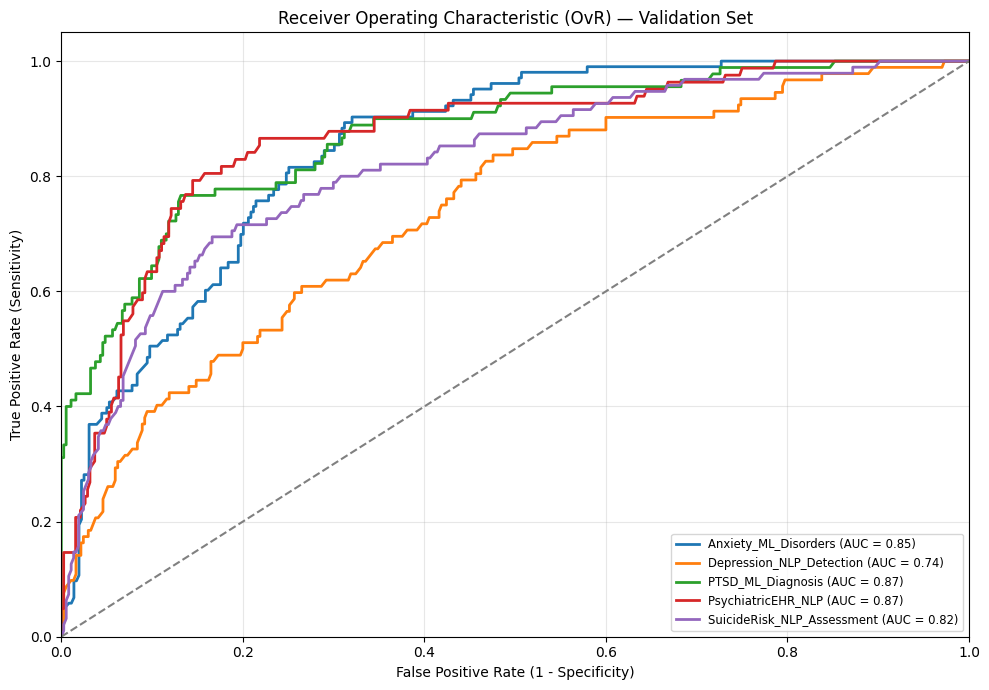


--- Visualizing Global Feature Importance ---


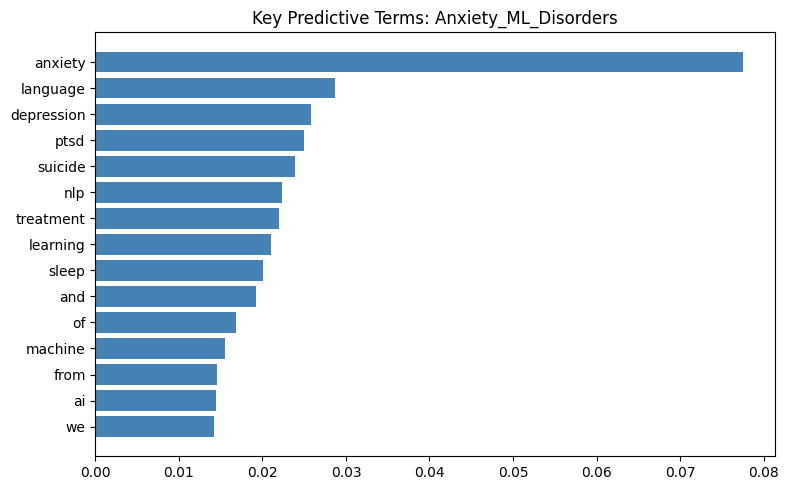

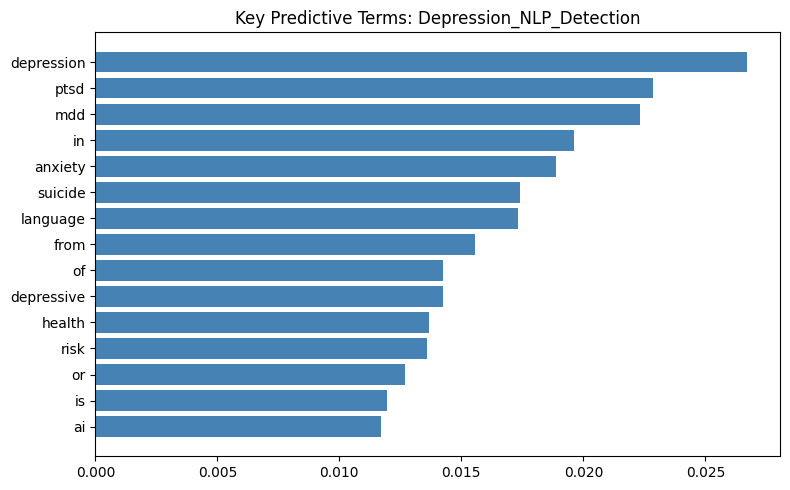

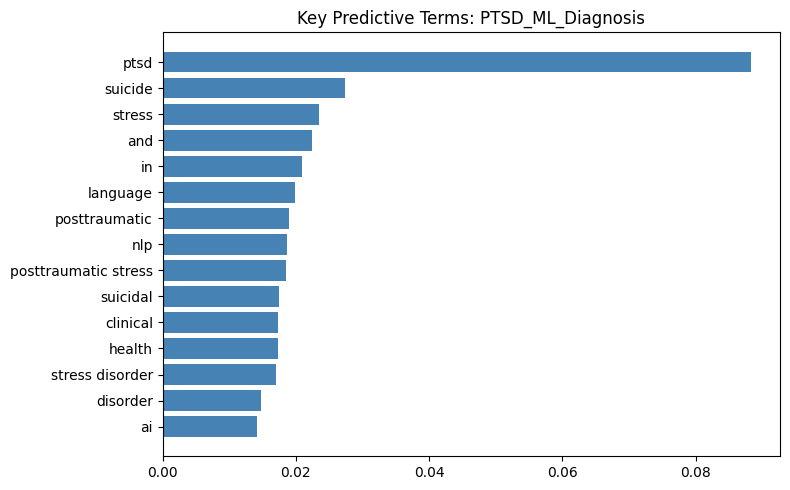

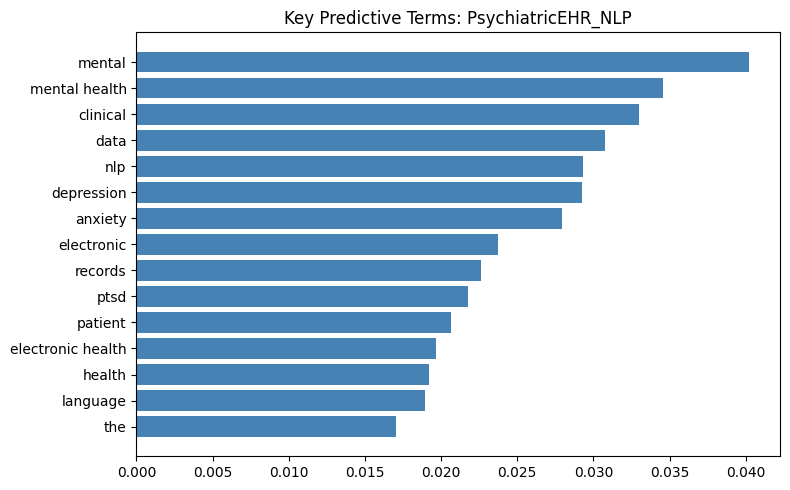

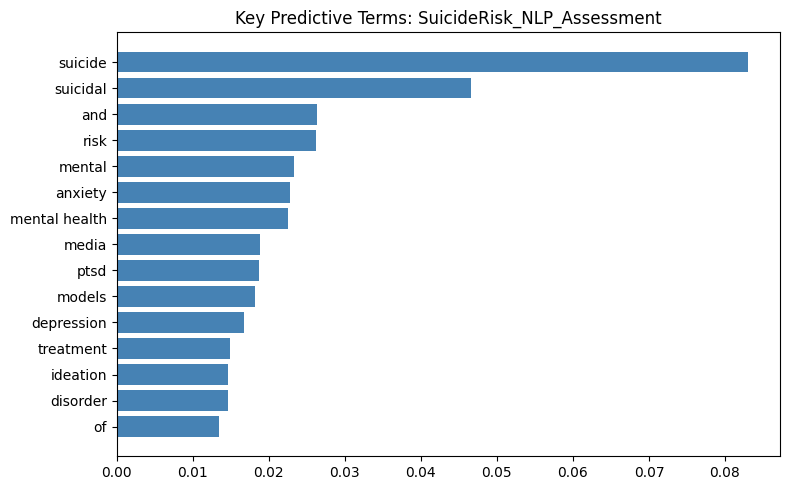


SAMPLE LOCAL ERROR ANALYSIS
TRUE: Depression_NLP_Detection | PRED: Anxiety_ML_Disorders
TEXT: harnessing digital health interventions to address the heterogeneity of depression a systematic review h4backgroundh4depression affects over 229 million people worldwide and ranks among the leading causes of disability and death particularly in young...

TRUE: Depression_NLP_Detection | PRED: Anxiety_ML_Disorders
TEXT: address heterogeneity in symptomatology biological underpinnings and treatment response across diverse patient populationsh4methodsh4the study followed prisma guidelines searching scopus ieee xplore and clinicaltrialsgov for englishlanguage peerrevie...

TRUE: Depression_NLP_Detection | PRED: Anxiety_ML_Disorders
TEXT: 25 randomized trials of justintime adaptive interventions eg the mello app demonstrated moderate to large effect sizes for reductions in depression idi 050 anxiety idi 061 and repetitive negative thinking rnt idi 087 smartmessaging postcognitive beha...



In [15]:
#----------------------------------------------------------------------------------------
#                     Results Interpretation and Error Analysis 
#----------------------------------------------------------------------------------------
# ---------- Paths ----------
TRAIN_PATH = "train_segments.csv"
VAL_PATH   = "val_segments.csv"
TEST_PATH  = "test_segments.csv"
RANDOM_STATE = 42

def build_model():
    """Consistent champion architecture: TF-IDF + Logistic Regression."""
    return Pipeline([
        ("vect", TfidfVectorizer(max_features=30000, ngram_range=(1, 2), lowercase=True)),
        ("clf", LogisticRegression(max_iter=6000, n_jobs=-1, random_state=RANDOM_STATE))
    ])

def plot_multiclass_roc(pipe, X_text, y_true, title_suffix="Set"):
    """
    Rubric Goal: 'Explain results effectively using graphs.'
    Generates OvR (One-vs-Rest) ROC curves for all psychiatric classes.
    """
    clf = pipe.named_steps["clf"]
    classes = clf.classes_
    
    # Binarize labels for multi-class ROC calculation
    y_bin = label_binarize(y_true, classes=classes)
    y_score = pipe.predict_proba(X_text)
    
    plt.figure(figsize=(10, 7))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                 label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, color='gray') # Random chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'Receiver Operating Characteristic (OvR) — {title_suffix}')
    plt.legend(loc="lower right", fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_shap_and_errors(pipe, train_df, val_df, n_local=3):
    """Generates Global bar charts and Local Error text output."""
    vect = pipe.named_steps["vect"]
    clf = pipe.named_steps["clf"]
    
    X_train_vec = vect.transform(train_df["text"].astype(str))
    X_val_vec = vect.transform(val_df["text"].astype(str))
    feature_names = np.array(vect.get_feature_names_out())
    class_names = clf.classes_

    # 1. Global SHAP
    explainer = shap.LinearExplainer(clf, X_train_vec, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_val_vec)
    
    # Normalize shape for multiclass
    shap_list = [shap_values[:, :, i] for i in range(shap_values.shape[2])] if shap_values.ndim == 3 else shap_values

    print("\n--- Visualizing Global Feature Importance ---")
    for ci, cname in enumerate(class_names):
        sv = shap_list[ci]
        mean_abs = np.asarray(np.abs(sv)).mean(axis=0)
        top_idx = np.argsort(mean_abs)[::-1][:15]
        
        plt.figure(figsize=(8, 5))
        plt.barh(feature_names[top_idx][::-1], mean_abs[top_idx][::-1], color='steelblue')
        plt.title(f"Key Predictive Terms: {cname}")
        plt.tight_layout()
        plt.show()

    # 2. Local Error Analysis (Mirroring your .txt logic)
    y_val = val_df["category"].astype(str).values
    val_pred = pipe.predict(val_df["text"].astype(str))
    mis_idx = np.where(val_pred != y_val)[0]

    print("\n" + "="*50 + "\nSAMPLE LOCAL ERROR ANALYSIS\n" + "="*50)
    for i in mis_idx[:n_local]:
        print(f"TRUE: {y_val[i]} | PRED: {val_pred[i]}")
        print(f"TEXT: {val_df['text'].iloc[i][:250]}...\n")

if __name__ == "__main__":
    # Load
    train_df = pd.read_csv(TRAIN_PATH)
    val_df = pd.read_csv(VAL_PATH)
    test_df = pd.read_csv(TEST_PATH)

    # Train
    pipe = build_model()
    pipe.fit(train_df["text"].astype(str), train_df["category"].astype(str))
    
    # 1. Visualize Model Separation (ROC)
    plot_multiclass_roc(pipe, val_df["text"].astype(str), val_df["category"].astype(str), "Validation Set")
    
    # 2. Visualize Model Logic (SHAP Global & Local)
    run_shap_and_errors(pipe, train_df, val_df)

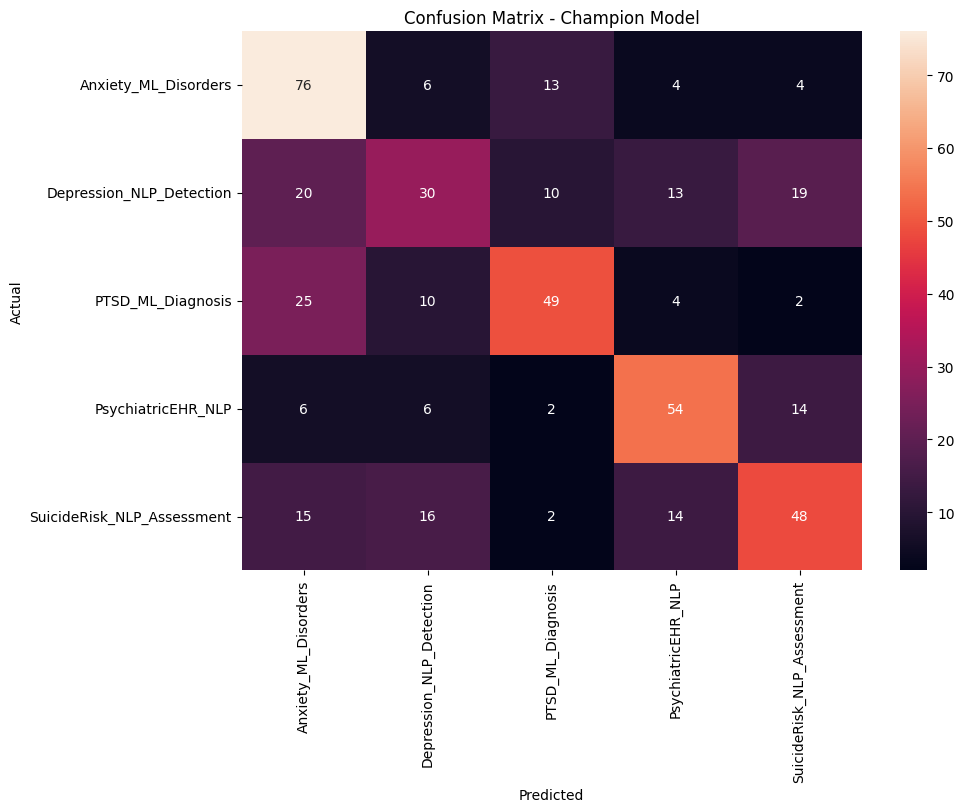

In [ ]:
#Confusion Matrix best model 
y_pred = pipe.predict(val_df["text"].astype(str))
cm = confusion_matrix(val_df["category"], y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=pipe.classes_, yticklabels=pipe.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Champion Model')
plt.show()

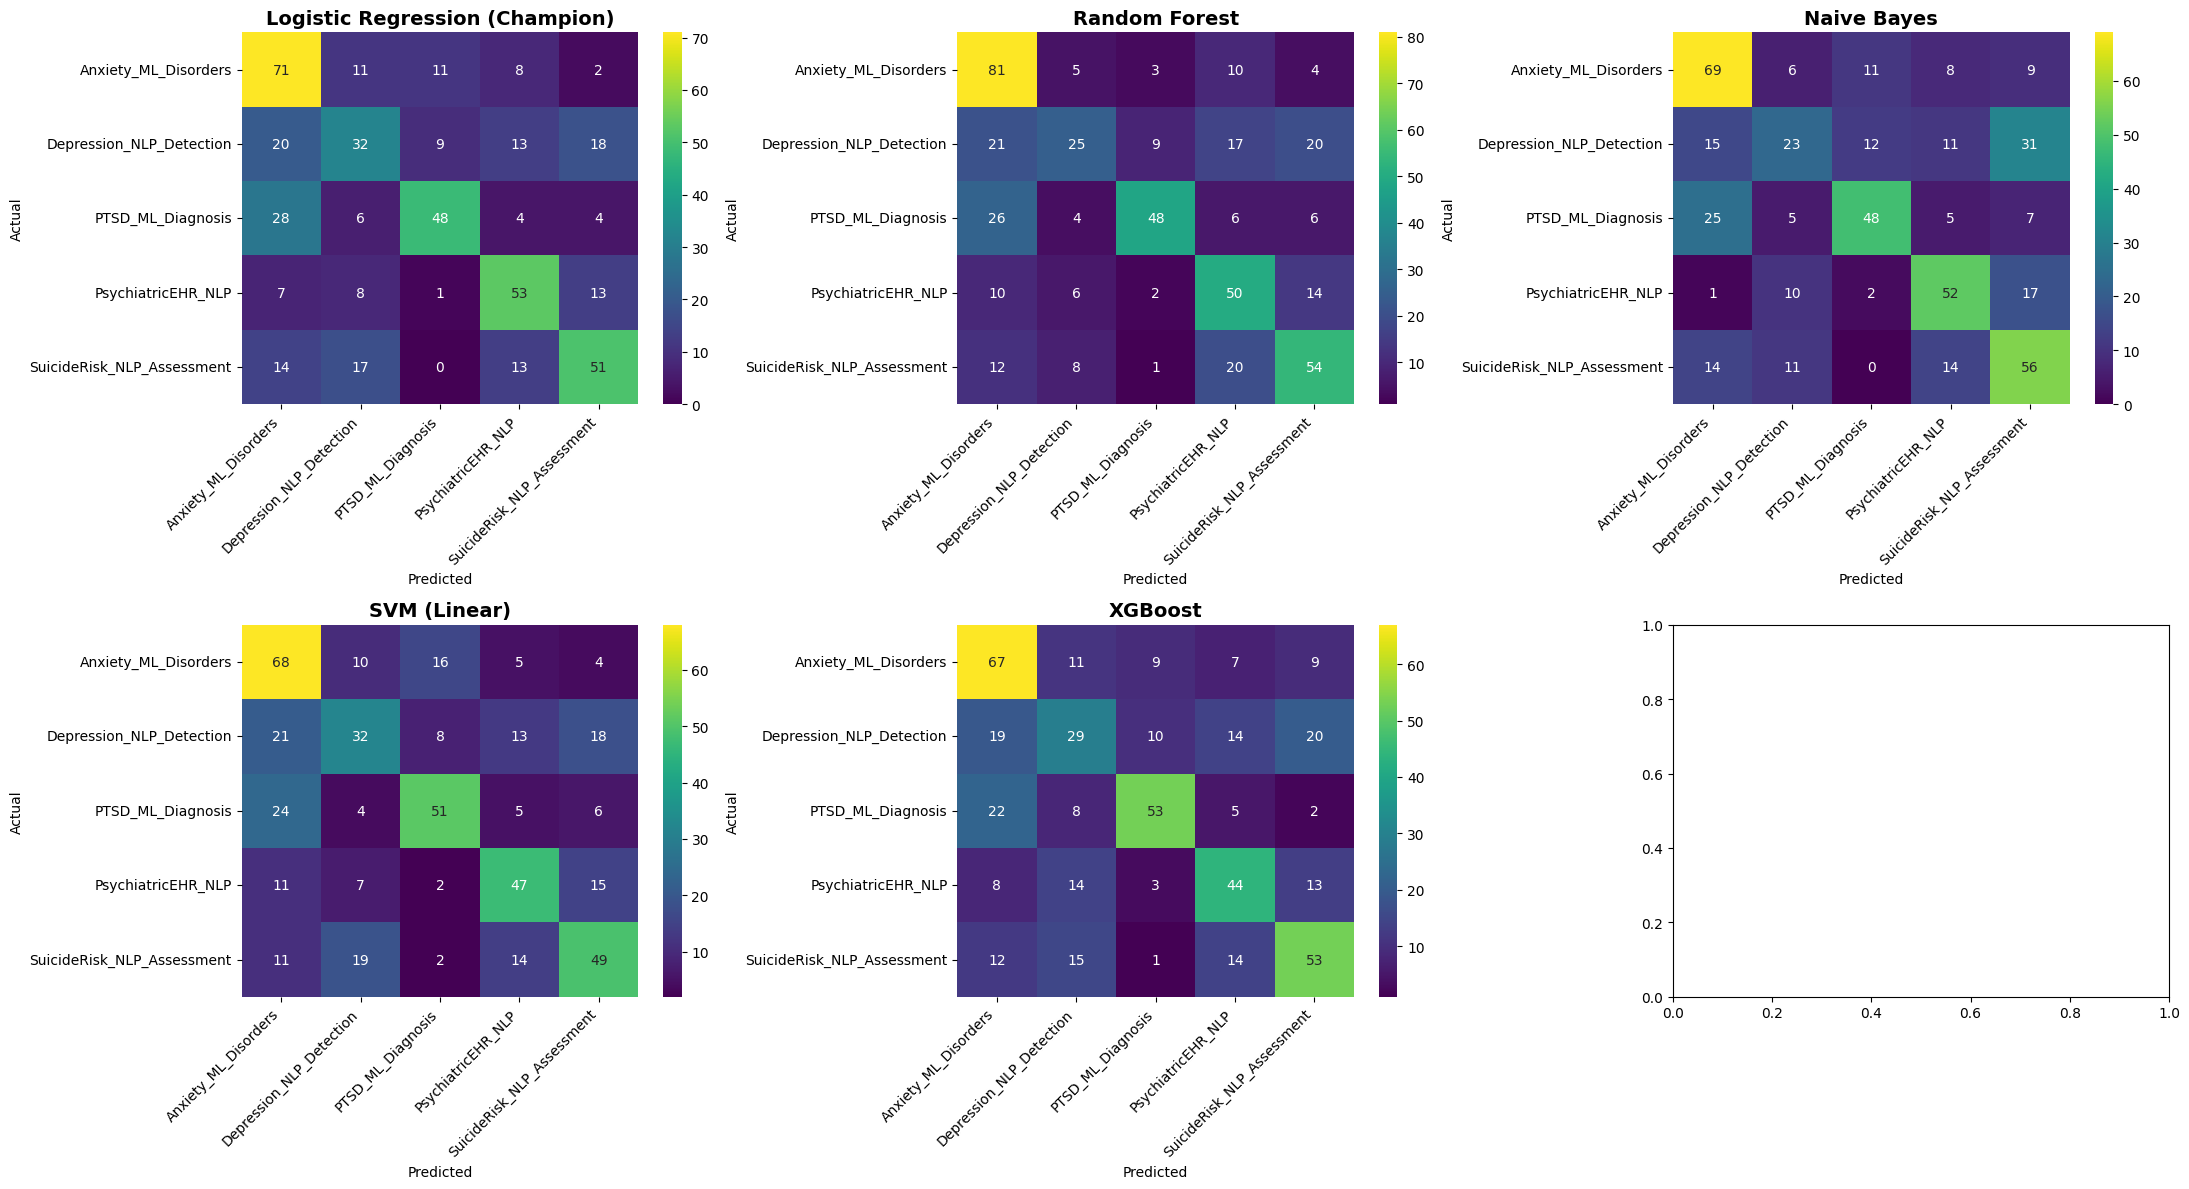

In [ ]:
# confusion matrix for the top 5 models.

# We use the same TF-IDF settings from your build_model()
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df["text"].astype(str))
X_val_tfidf = tfidf.transform(val_df["text"].astype(str))

# Encode labels for XGBoost (it requires numbers)
le = LabelEncoder()
y_train_num = le.fit_transform(train_df["category"])
y_val_num = le.transform(val_df["category"])

models = {
    "Logistic Regression (Champion)": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear)": LinearSVC(),
    "XGBoost": XGBClassifier()
}

# 2. Setup Plot
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()
labels = sorted(train_df["category"].unique())

for i, (name, model) in enumerate(models.items()):
    # Fit
    if name == "XGBoost":
        model.fit(X_train_tfidf, y_train_num)
        y_pred_num = model.predict(X_val_tfidf)
        y_pred = le.inverse_transform(y_pred_num)
    else:
        model.fit(X_train_tfidf, train_df["category"])
        y_pred = model.predict(X_val_tfidf)
    
    # Plot
    cm = confusion_matrix(val_df["category"], y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', ax=axes[i],
                xticklabels=labels, yticklabels=labels)
    axes[i].set_title(name, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
#----------------------------------------------------------------------------------------
#                     BERT Analysis 
#----------------------------------------------------------------------------------------


from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import os

# Optional: Suppress the HF Hub warning (or just ignore it)
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# 1. Dataset Class (Matches your clinical abstract structure)
class MedicalDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Tokenize Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_df['text'].astype(str)), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_df['text'].astype(str)), truncation=True, padding=True, max_length=128)

# 3. Encode Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_df["category"])
y_val = le.transform(val_df["category"])

train_dataset = MedicalDataset(train_encodings, y_train)
val_dataset = MedicalDataset(val_encodings, y_val)

# 4. Load Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# 5. Corrected Training Arguments
# Note: changed 'evaluation_strategy' to 'eval_strategy'
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",  # Corrected keyword here
    save_strategy="epoch",
    load_best_model_at_end=True
)

# 6. Initialize and Run Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

print("Starting BERT training on Clinical Data...")
trainer.train()

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1030.98it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those p

Starting BERT training on Clinical Data...


Epoch,Training Loss,Validation Loss
1,No log,1.201507
2,1.312159,1.144672
3,1.312159,1.154351


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer

TrainOutput(global_step=840, training_loss=1.1528843834286644, metrics={'train_runtime': 850.0764, 'train_samples_per_second': 7.902, 'train_steps_per_second': 0.988, 'total_flos': 441841140732672.0, 'train_loss': 1.1528843834286644, 'epoch': 3.0})

In [26]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # Weighted F1 is best for clinical data to account for category variations
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

# Update the trainer with the metric function
trainer.compute_metrics = compute_metrics

In [28]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

# Update trainer with metrics and a larger evaluation batch size
trainer.compute_metrics = compute_metrics
trainer.args.per_device_eval_batch_size = 32  # Faster on CPU

# Prepare a subset of the Training data (to avoid the long wait)
train_subset = torch.utils.data.Subset(train_dataset, range(min(100, len(train_dataset))))

print("--- Running BERT Evaluations ---")

# 1. Validation Results (Usually fast enough)
val_results = trainer.evaluate(val_dataset)
print(f"Validation Accuracy: {val_results['eval_accuracy']:.4f}")

# 2. Test Results
test_encodings = tokenizer(list(test_df['text'].astype(str)), truncation=True, padding=True, max_length=128)
y_test = le.transform(test_df["category"])
test_dataset = MedicalDataset(test_encodings, y_test)
test_results = trainer.evaluate(test_dataset)
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")

# 3. Training Results (On the subset)
train_results = trainer.evaluate(train_subset)
print(f"Training (Subset) Accuracy: {train_results['eval_accuracy']:.4f}")

--- Running BERT Evaluations ---


Validation Accuracy: 0.5519
Test Accuracy: 0.5181
Training (Subset) Accuracy: 0.2500
